# Prescribing outcomes
### 1. Change from baseline in the rate of nimodipine prescribing per 1,000 registered patients compared to the change in an earlier control period. 

**Follow-up period**: Three months following intervention, not including month of sending.

**Baseline period:** latest available three months of data at start of study.

**Control period:** baseline period minus one year, follow-up period minus one year. 


In [1]:
###  update dates as appropriate
import datetime

d7 = '2018-10-01' # month after end of follow-up period (NB update to 2019)
d6 = '2018-07-01' # start of 3-month follow-up period (NB update to 2019)

d5 = '2018-10-01' # month after end of "follow-up" period (one year prior to actual follow-up) 
d4 = '2018-07-01' # start of 3-month "follow-up" period (one year prior to actual follow-up)

d3 = '2018-04-01' # month after end of "baseline" period
d2 = '2018-01-01' # start of 3-month "baseline" period
d1 = '2017-04-01' # start of 12-month "baseline" period

In [2]:
import pandas as pd

In [3]:
# load csv of practices contacted 
nim = pd.read_csv('nimodipine_practices.csv')
nim = nim.rename(columns={"practice_":"practice"})
nim.head()

,Unnamed: 0,practice,12-mo_items,12-mo_quantity,12-mo_total_list_size,3-mo_items,3-mo_quantity,3-mo_total_list_size
0,0,A82036,11,594,10106.750000,2,90,10191.000000
1,1,A83047,13,2812,14751.900000,5,1120,14805.333333
2,2,B82005,1,100,58595.000000,1,100,58595.000000
3,3,B86081,11,924,14308.909091,3,252,14355.666667
4,4,C81110,6,1344,10537.833333,1,224,10623.000000


In [4]:
#  import all nimodipine data, excluding practices not meeting the eligibility criteria. 

# table to query set up as follows
'''SELECT * FROM 
`ebmdatalab.hscic.normalised_prescribing_standard` 
WHERE SUBSTR(bnf_code,1,9) = '0206020M0'
AND EXTRACT(year FROM month) > 2016 '''

#### save as helen.nimodipine_20190513


# import data for all practices prescribing nimodipine, 
# excluding those which are dormant/closed,
# excluding practices which are not standard general practices
# excluding practices in Devon CCG (or one of its predecessor organisations NEW Devon CCG)

# Import dataset from BigQuery
import pandas as pd
import numpy as np
GBQ_PROJECT_ID = '620265099307'

q = '''SELECT  
    a.practice,
    a.pct,
    setting,
    a.month,
    total_list_size,
    SUM(a.items) AS items,
    SUM(a.quantity) AS quantity
FROM helen.nimodipine_20190513 a
   INNER JOIN hscic.practices b ON a.practice = b.code AND setting=4 
   INNER JOIN `hscic.practice_statistics_all_years` pop  ON a.practice = pop.practice AND a.month = pop.month and status_code = "A"
WHERE pct NOT IN ('99P','15N')
    AND pop.total_list_size > 1000 
    AND (male_25_34 + male_35_44 + male_45_54 + male_55_64 + female_25_34 + female_35_44 + female_45_54 + female_55_64)
    / total_list_size BETWEEN 0.1 and 0.85
GROUP BY practice, pct, setting, month, total_list_size
'''
df1 = pd.read_gbq(q, GBQ_PROJECT_ID, dialect='standard',verbose=False)

        ## note: parsing dates is quite memory-intensive, make sure not too many programmes running

df1["month"] = pd.to_datetime(df1.month)

df1.head() # this gives the first few rows of data

C:\Users\hcurtis\Anaconda3\lib\site-packages\pandas\io\gbq.py:149: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  credentials=credentials, verbose=verbose, private_key=private_key)


,practice,pct,setting,month,total_list_size,items,quantity
0,G82032,09J,4,2018-03-01 00:00:00+00:00,13884,1,22
1,C81110,04R,4,2017-05-01 00:00:00+00:00,10403,1,224
2,C84018,04K,4,2017-08-01 00:00:00+00:00,9453,1,30
3,H81029,09N,4,2018-03-01 00:00:00+00:00,11800,1,100
4,M83128,05W,4,2017-04-01 00:00:00+00:00,4273,1,72


In [5]:
# classify dates as part of follow-up period 

df1["follow-up"] = False
df1.loc[(df1['month']>=d6)&(df1['month']<d7), "follow-up"] = True

fu = df1.loc[df1["follow-up"]==True].groupby(["practice"])["quantity","total_list_size"].agg({"quantity":"sum","total_list_size":"mean"}).reset_index()

fu.head()

,practice,quantity,total_list_size
0,A82029,200,3488.5
1,A82036,112,10122.0
2,A83029,100,4928.0
3,A83047,572,14743.5
4,A84011,400,7526.5


### Merge baseline and follow-up data

In [6]:

nim2 = nim[["practice","3-mo_quantity","3-mo_total_list_size"]].merge(fu, on="practice",how="left")
nim2["baseline_rate"] = 1000*nim2["3-mo_quantity"]/nim2["3-mo_total_list_size"]
nim2["follow-up_rate"] = 1000*nim2["quantity"]/nim2["total_list_size"]
nim2 = nim2.fillna(0)
nim2.head()

,practice,3-mo_quantity,3-mo_total_list_size,quantity,total_list_size,baseline_rate,follow-up_rate
0,A82036,90,10191.000000,112.0,10122.000000,8.831322,11.065007
1,A83047,1120,14805.333333,572.0,14743.500000,75.648415,38.796758
2,B82005,100,58595.000000,0.0,0.000000,1.706630,0.000000
3,B86081,252,14355.666667,252.0,14303.333333,17.554044,17.618271
4,C81110,224,10623.000000,224.0,10522.000000,21.086322,21.288728


In [7]:
nim3 = nim2.copy()

nim3 = nim3.drop("practice",axis=1).mean()

print(nim3)

3-mo_quantity             225.661017
3-mo_total_list_size    12791.403955
quantity                  187.796610
total_list_size          8262.161017
baseline_rate              25.958306
follow-up_rate             22.897705
dtype: float64


In [8]:
from scipy import stats

print(stats.ttest_rel(nim2["baseline_rate"],nim2["follow-up_rate"]))



Ttest_relResult(statistic=1.171121009095174, pvalue=0.24633908522948783)


### identify control practices based on 12-month and 3-month prescribing data

In [9]:
### classify data by baseline and follow-up period

df2 = df1.copy()

df2["follow-up"] = False
df2["12-mo-baseline"] = False
df2["3-mo-baseline"] = False
df2.loc[(df2['month']>=d1)&(df2['month']<d3), "12-mo-baseline"] = True
df2.loc[(df2['month']>=d2)&(df2['month']<d3), "3-mo-baseline"] = True
df2.loc[(df2['month']>=d4)&(df2['month']<d5), "follow-up"] = True

df2.head()

,practice,pct,setting,month,total_list_size,items,quantity,follow-up,12-mo-baseline,3-mo-baseline
0,G82032,09J,4,2018-03-01 00:00:00+00:00,13884,1,22,False,True,True
1,C81110,04R,4,2017-05-01 00:00:00+00:00,10403,1,224,False,True,False
2,C84018,04K,4,2017-08-01 00:00:00+00:00,9453,1,30,False,True,False
3,H81029,09N,4,2018-03-01 00:00:00+00:00,11800,1,100,False,True,True
4,M83128,05W,4,2017-04-01 00:00:00+00:00,4273,1,72,False,True,False


In [10]:

# any prescribing in last 3 months
filter1 = df2.loc[df2["3-mo-baseline"]==True].groupby(["practice"])["items","quantity","total_list_size"].agg({"items":"sum","quantity":"sum","total_list_size":"mean"}).reset_index()
filter1 = filter1.rename(columns={"items":"3-mo_items","quantity":"3-mo_quantity", "total_list_size":"3-mo_total_list_size"})

#sum over 12 months
agg = df2.loc[df2["12-mo-baseline"]==True].groupby(["practice"])["items","quantity","total_list_size"].agg({"items":"sum","quantity":"sum","total_list_size":"mean"}).reset_index()

agg = agg.merge(filter1, on="practice", how="inner")#.groupby(["practice","3-mo-baseline"]).sum()
agg = agg.rename(columns={"items":"12-mo_items","quantity":"12-mo_quantity", "total_list_size":"12-mo_total_list_size"})

# More than one item of nimodipine prescribed OR more than 56 tablets prescribed in the latest 12 months#
agg = agg.loc[(agg["12-mo_items"]>1) | (agg["12-mo_quantity"]>56)]#.sort_values(by="quantity")
agg

,practice,12-mo_items,12-mo_quantity,12-mo_total_list_size,3-mo_items,3-mo_quantity,3-mo_total_list_size
0,A81009,1,200,8740.000000,1,200,8740.000000
1,A82029,7,700,3488.571429,1,100,3484.000000
2,A82036,13,728,10014.636364,2,112,10029.000000
3,A82045,12,672,8617.727273,2,112,8644.500000
4,A82654,6,672,7607.333333,1,112,7631.000000
5,A83029,3,336,4893.333333,3,336,4893.333333
6,A83047,12,2688,14572.800000,2,448,14652.000000
7,A84009,1,112,23256.000000,1,112,23256.000000
8,B86060,5,524,9114.800000,2,224,9139.500000
9,B86081,8,688,14128.142857,2,168,14290.500000


In [11]:
# follow-up data for comparison group ("control")

con = agg[["practice","3-mo_quantity","3-mo_total_list_size"]].copy()
con["baseline_rate"] = 1000*con["3-mo_quantity"]/con["3-mo_total_list_size"]

con_fu = df1.loc[df1["follow-up"]==True].groupby(["practice"])["quantity","total_list_size"].agg({"quantity":"sum","total_list_size":"mean"}).reset_index()


con = con.merge(con_fu, on="practice",how="left")

# fill missing population figures with the earlier population, and fill blank quantities with zero
con["total_list_size"] = con["total_list_size"].fillna(con["3-mo_total_list_size"])
con = con.fillna(0)
con["follow-up_rate"] = 1000*con["quantity"]/con["total_list_size"]
con.head()

,practice,3-mo_quantity,3-mo_total_list_size,baseline_rate,quantity,total_list_size,follow-up_rate
0,A81009,200,8740.0,22.883295,0.0,8740.0,0.000000
1,A82029,100,3484.0,28.702641,200.0,3488.5,57.331231
2,A82036,112,10029.0,11.167614,112.0,10122.0,11.065007
3,A82045,112,8644.5,12.956215,0.0,8644.5,0.000000
4,A82654,112,7631.0,14.676975,0.0,7631.0,0.000000


In [13]:
con2 = con.copy()

con2 = pd.DataFrame(con2.drop("practice",axis=1).sum()).transpose()

con2["follow-up_rate"] = 1000*con2["quantity"]/con2["total_list_size"]

con2

,3-mo_quantity,3-mo_total_list_size,baseline_rate,quantity,total_list_size,follow-up_rate
0,17556.0,836670.166667,2044.422339,11768.0,884578.833333,13.303506


In [14]:
con2 = con.copy()

con2 = con2.drop("practice",axis=1).mean()

#con2["follow-up_rate"] = 1000*con2["quantity"]/con2["total_list_size"]

print(con2)

3-mo_quantity             237.243243
3-mo_total_list_size    11306.353604
baseline_rate              27.627329
quantity                  159.027027
total_list_size         11953.768018
follow-up_rate             18.143416
dtype: float64


In [15]:
from scipy import stats

print(stats.ttest_rel(con["baseline_rate"],con["follow-up_rate"]))



Ttest_relResult(statistic=3.1975569941493442, pvalue=0.0020499113494548654)


# 2. Change from baseline in overall rate of nimodipine prescribing per 1,000 population, across all practices in England.
For our secondary prescribing outcome we will assess the national change in rate of nimodipine prescribing across all practices using interrupted time series analysis. 

In [16]:
GBQ_PROJECT_ID = '620265099307'

q = '''SELECT  
    a.month,
    SUM(total_list_size) as total_list_size,
    SUM(a.items) AS items,
    SUM(a.quantity) AS quantity
FROM helen.nimodipine_20190513 a
   INNER JOIN hscic.practices b ON a.practice = b.code AND setting=4 
   INNER JOIN `hscic.practice_statistics_all_years` pop  ON a.practice = pop.practice AND a.month = pop.month
WHERE pct NOT IN ('99P','15N')
GROUP BY month
'''
df4 = pd.read_gbq(q, GBQ_PROJECT_ID, dialect='standard',verbose=False)

        ## note: parsing dates is quite memory-intensive, make sure not too many programmes running

df4["month"] = pd.to_datetime(df4.month)

df4.head() # this gives the first few rows of data

C:\Users\hcurtis\Anaconda3\lib\site-packages\pandas\io\gbq.py:149: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  credentials=credentials, verbose=verbose, private_key=private_key)


,month,total_list_size,items,quantity
0,2017-12-01 00:00:00+00:00,523681,75,6587
1,2018-01-01 00:00:00+00:00,515884,72,6520
2,2019-01-01 00:00:00+00:00,469797,46,4592
3,2019-02-01 00:00:00+00:00,439546,53,4912
4,2018-03-01 00:00:00+00:00,491813,65,6103


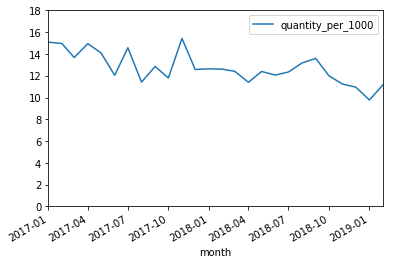

In [17]:
import matplotlib.pyplot as plt

df5 = df4.copy()
df5["quantity_per_1000"] = 1000*df5["quantity"]/df5["total_list_size"]

df5.plot("month","quantity_per_1000")
plt.ylim((0,18))

plt.show()

### export data for ITSA analysis in STATA

In [ ]:
df5.to_csv("nimodipine_national_for_itsa.csv")